In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
paths = []
labels = []
root_path = r"/content/drive/MyDrive/TESS Toronto emotional speech set data"

for dirname, _, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.endswith(".wav"):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            labels.append(label.lower())
        if len(paths) == 2800:
            break
print('Dataset is loaded')

Dataset is loaded


In [ ]:
len(paths)

2800

In [ ]:
paths[:10]

['/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_bar_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_back_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_hit_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_live_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_take_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_mood_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_date_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_came_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_ripe_neutral.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_neutral/OAF_such_neutral.wav']

In [ ]:
labels[:5]

['neutral', 'neutral', 'neutral', 'neutral', 'neutral']

In [ ]:
#Create Dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()

df['labels'].value_counts()

,count
labels,
neutral,400
sad,400
fear,400
ps,400
happy,400
disgust,400
angry,400


# **Exploratory Data Analysis**

<Axes: xlabel='labels', ylabel='count'>

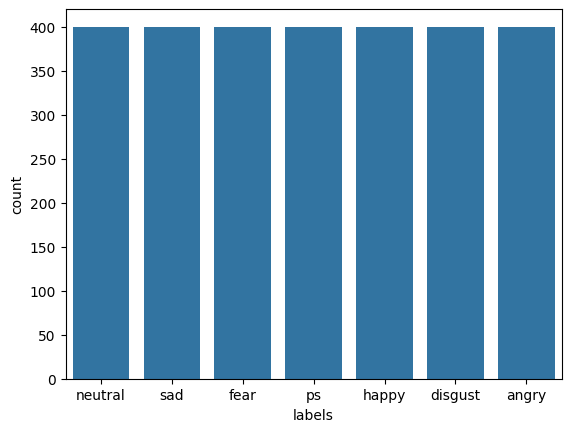

In [ ]:
sns.countplot(data = df, x = 'labels')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size = 20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size = 20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

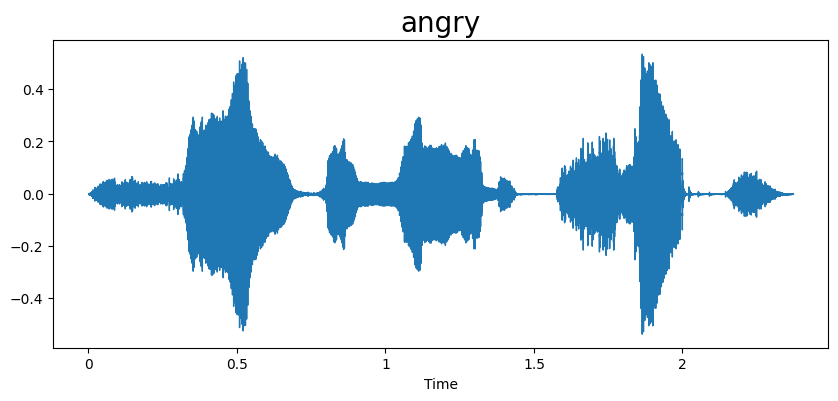

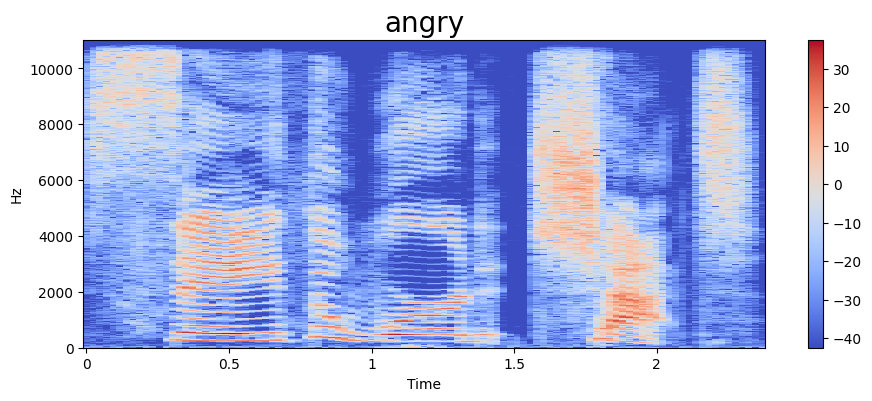

In [ ]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

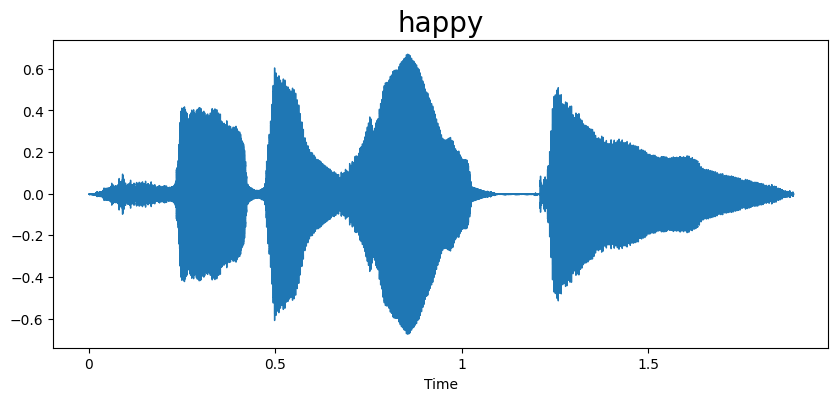

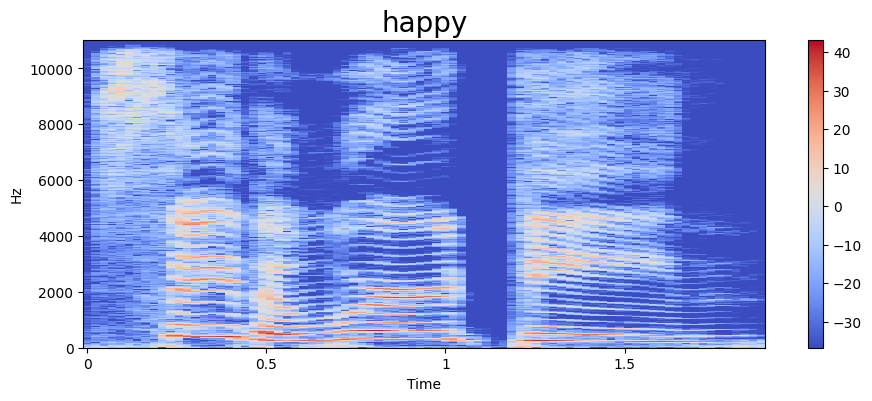

In [ ]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


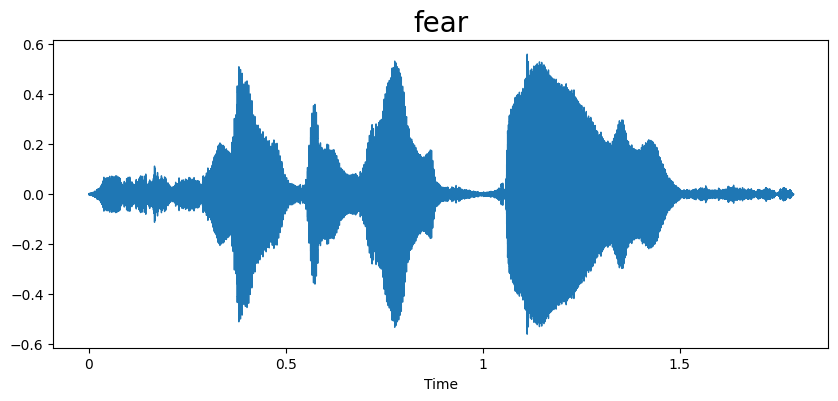

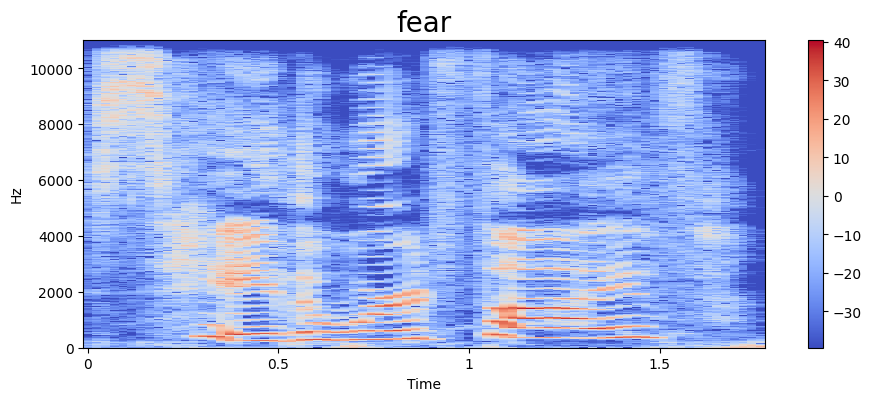

In [ ]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

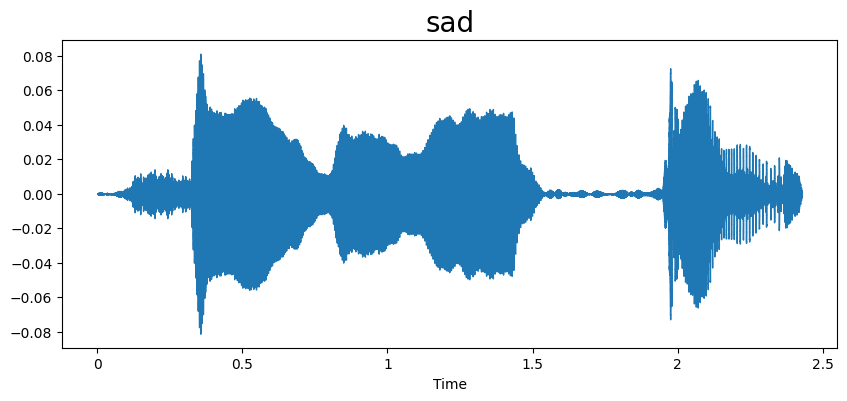

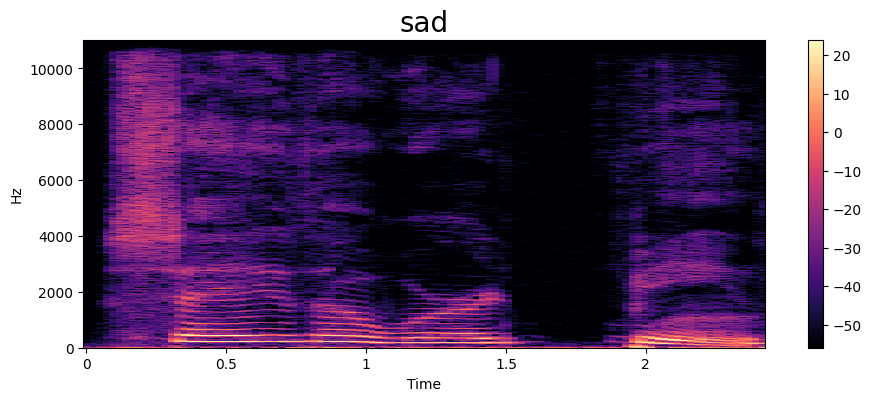

In [ ]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


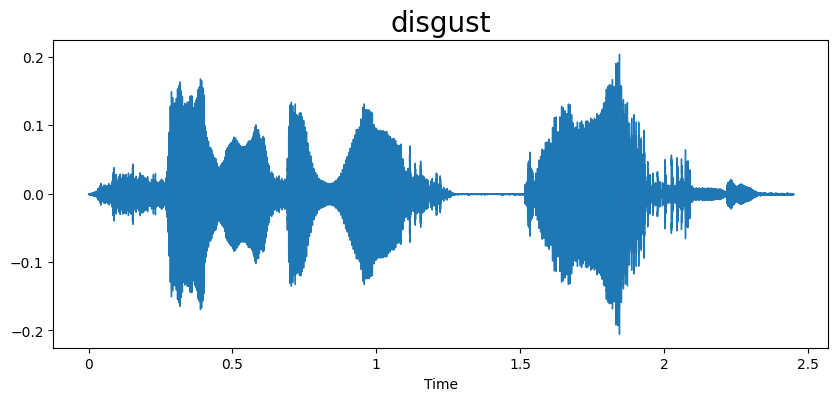

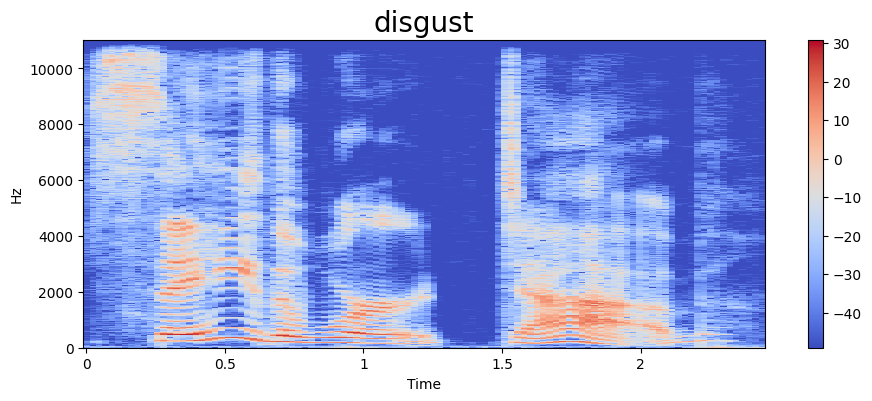

In [ ]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

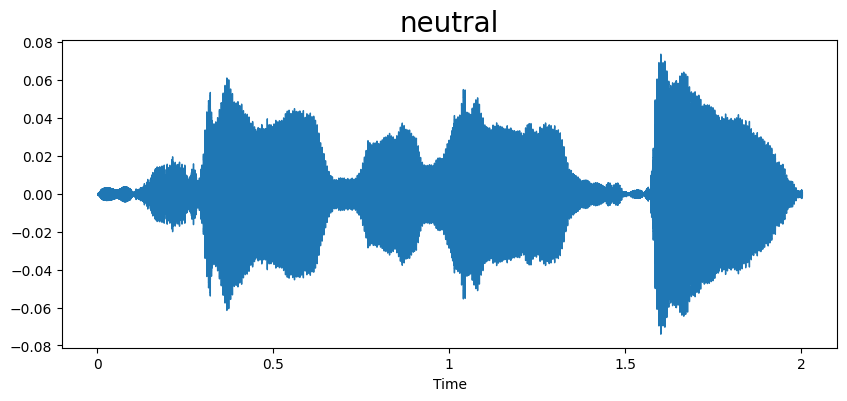

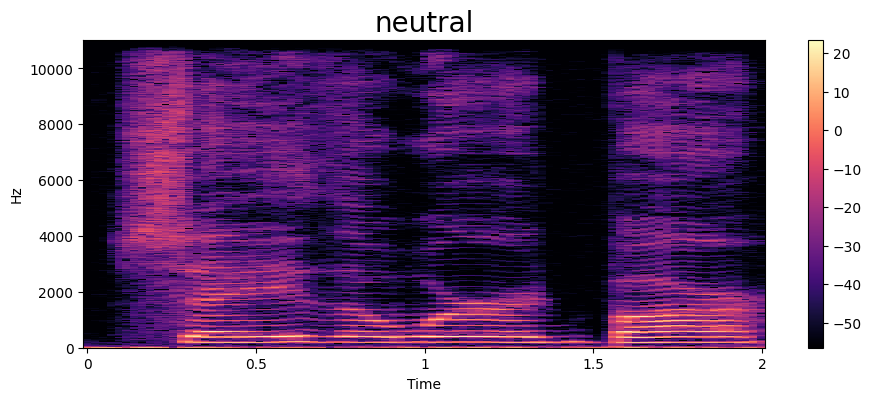

In [ ]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

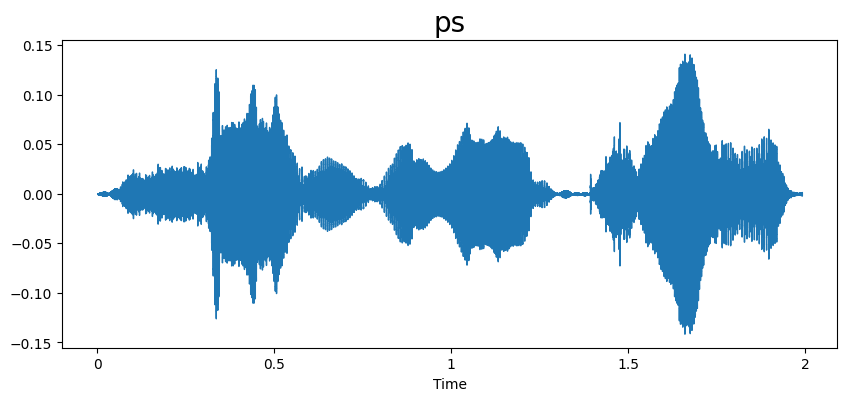

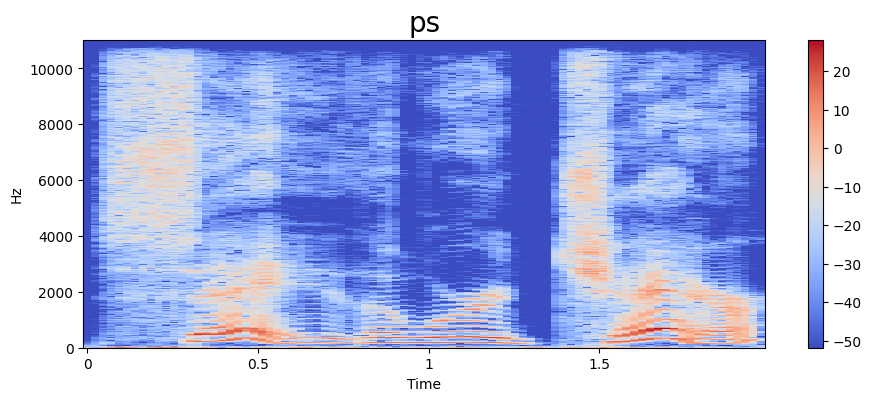

In [ ]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# **Create Custom Dataset Class**

In [ ]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head(2)

,audio_paths,labels
0,/content/drive/MyDrive/TESS Toronto emotional ...,0
1,/content/drive/MyDrive/TESS Toronto emotional ...,0


In [ ]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels']==2])[0]
data, sampling_rate = librosa.load(path)
len(data)

39418

In [ ]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels']==2])[0]
data, sampling_rate = librosa.load(path)
len(data)
print(sampling_rate)
sampling_rate * 2

22050


44100

In [ ]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df.reset_index(drop=True)  # Ensures indices are 0 to N-1
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        # Load the audio file
        speech, sr = librosa.load(audio_path, sr=16000)  # Set target sampling rate

        # Pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Preprocess the audio
        inputs = self.processor(
            speech, sampling_rate=16000, return_tensors='pt',
            padding=True, truncation=True, max_length=self.max_length
        )

        input_values = inputs.input_values.squeeze()
        return {
            'input_values': input_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
#split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, stratify=df['labels'])

In [ ]:
#initialize the processors and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels = 7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [ ]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

In [ ]:
#create data loaders
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

# **Set Training Arguments**

In [ ]:
# Define output directory
output_dir = './results'

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    run_name="wav2vec2-emotion-classification",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    num_train_epochs=5,
    weight_decay=0.05,
    logging_dir='./logs',
)

In [ ]:
#Create function for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids # Original labels
    preds = np.argmax(pred.predictions, axis=1)  # Model predicted labels

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
trainer = Trainer(
    model = model,
    args= Training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Start the training process
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kalasikavundya (kalasikavundya-sliit-academy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.989800
1000,0.148400


TrainOutput(global_step=1400, training_loss=0.42784111022949217, metrics={'train_runtime': 1366.7961, 'train_samples_per_second': 8.194, 'train_steps_per_second': 1.024, 'total_flos': 2.033641344e+17, 'train_loss': 0.42784111022949217, 'epoch': 5.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.0597451888024807, 'eval_accuracy': 0.9982142857142857, 'eval_precision': 0.998236331569665, 'eval_recall': 0.9982142857142857, 'eval_f1': 0.9982142159570966, 'eval_runtime': 246.7192, 'eval_samples_per_second': 2.27, 'eval_steps_per_second': 0.284, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Get predictions from trainer
outputs = trainer.predict(test_dataset)
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=1)

In [ ]:
# Print class-wise report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=inverse_label_map.values()))


Classification Report:

              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00        80
         sad       0.99      1.00      0.99        80
        fear       1.00      1.00      1.00        80
          ps       1.00      1.00      1.00        80
       happy       1.00      1.00      1.00        80
     disgust       1.00      0.99      0.99        80
       angry       1.00      1.00      1.00        80

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



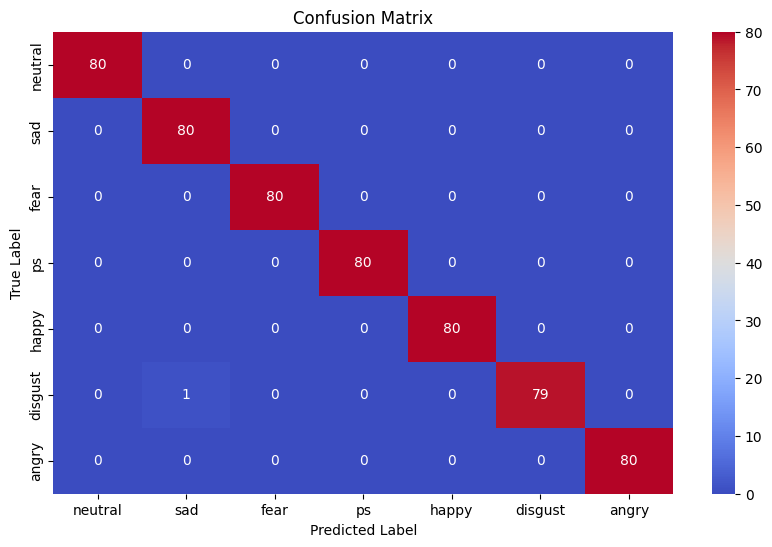

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=inverse_label_map.values(),
            yticklabels=inverse_label_map.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **Test Prediction**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import random
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_values)

logits = output.logits

Original Label: disgust


In [ ]:
# Get the predicted class from the logits
predicted_class = logits.argmax(dim=-1).item()
print("Predicted Label:", inverse_label_map[predicted_class])

import random
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_values)

logits = output.logits


Predicted Label: disgust
Original Label: disgust


In [ ]:

# Get the predicted class from the logits
predicted_class = logits.argmax(dim=-1).item()
print("Predicted Label:", inverse_label_map[predicted_class])

Predicted Label: disgust


In [ ]:

from IPython.display import Audio, display

def test_random_prediction_with_audio():
    idx = random.randrange(len(test_dataset))
    sample = test_dataset[idx]
    true_label = inverse_label_map[sample['labels'].item()]
    audio_path = test_df.iloc[idx]['audio_paths']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_values = sample['input_values'].unsqueeze(0).to(device)
    model.to(device)

    with torch.no_grad():
        output = model(input_values)

    pred_label = inverse_label_map[output.logits.argmax(dim=-1).item()]

    print(f"\nActual Emotion   : {true_label}")
    print(f"Predicted Emotion: {pred_label}")
    print("Playing test audio...")

    display(Audio(audio_path))
test_random_prediction_with_audio()


Actual Emotion   : sad
Predicted Emotion: sad
Playing test audio...


In [ ]:
# Define output directory for saving the model
model_output_dir = "./saved_model"
os.makedirs(model_output_dir, exist_ok=True)

In [ ]:
# Save inverse_label_map to a JSON file
with open(os.path.join(model_output_dir, 'label_map.json'), 'w') as f:
    json.dump(inverse_label_map, f)

In [ ]:
# Save the model
model.save_pretrained(model_output_dir)
processor.save_pretrained(model_output_dir)

print(f"Model and processor saved to {model_output_dir}")

Model and processor saved to ./saved_model


In [ ]:

from google.colab import files
import shutil

# Zip the model directory
shutil.make_archive("saved_model", 'zip', "saved_model")

'/content/saved_model.zip'

In [ ]:
files.download("saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>